# Финальный проект "Рекомендательные системы"

- Целевая метрика - money precision@5. Порог для уcпешной сдачи проекта money precision@5 > 20%

Бизнес ограничения в топ-5 товарах:
- Для каждого юзера 5 рекомендаций (иногда модели могут возвращать < 5)
- **2 новых товара** (юзер никогда не покупал)
- **1 дорогой товар, > 7 долларов** (price = sum(sales_value) / sum(quantity))
- **Все товары из разных категорий** (категория - sub_commodity_desc)  
- **Стоимость каждого рекомендованного товара > 1 доллара**  (price = sum(sales_value) / sum(quantity))
- НЕТ ограничения на СТМ
- Вам нужно добавить обрааботку холодных юзеров (рекомендовать им топ-5 популярных товаров)

- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и .csv файл с рекомендациями. В .csv файле 2 столбца: user_id - (item_id1, item_id2, ..., item_id5)  

**Установим необходимые библиотеки**

In [1]:
!pip install implicit

**Подключим нужные библиотеки**

In [2]:
import pandas as pd
import numpy as np

import lightgbm
from lightgbm import LGBMClassifier
from scipy.sparse import csr_matrix

from tqdm import tqdm
tqdm.pandas()

# Матричная факторизация
from implicit.nearest_neighbours import ItemItemRecommender
from implicit.nearest_neighbours import bm25_weight
from implicit.als import AlternatingLeastSquares

import warnings
warnings.filterwarnings('ignore')

In [3]:
import implicit
implicit.__version__

'0.4.4'

In [4]:
pd.set_option('display.max_columns', None)

**Подключим Гугл Диск**

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Добавим в проект написанные нами ранее полезные функции**

In [6]:
def prefilter_items(data, take_n_popular=5000, item_features=None):
    # уберем самые популярные товары (их и так купят)
    popularity = data.groupby('item_id')['user_id'].nunique().reset_index() / data['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)

    top_popular = popularity[popularity['share_unique_users'] > 0.25].item_id.tolist()
    data = data[~data['item_id'].isin(top_popular)]

    # уберем самые НЕ популярные товары (их и так НЕ купят)
    top_not_popular = popularity[popularity['share_unique_users'] < 0.03].item_id.tolist()
    data = data[~data['item_id'].isin(top_not_popular)]

    # уберем не интересные для рекомендаций категории (department)
    if item_features is not None:
        dep_size = pd.DataFrame(item_features. \
                                groupby('department')['item_id'].nunique(). \
                                sort_values(ascending=False)).reset_index()

        dep_size.columns = ['department', 'n_items']
        not_popular_departments = dep_size[dep_size['n_items'] < 180].department.tolist()
        items_in_not_popular_departments = item_features[
            item_features['department'].isin(not_popular_departments)].item_id.unique().tolist()

        data = data[~data['item_id'].isin(items_in_not_popular_departments)]

    # уберем товары, которые не продавались за последние 12 месяцев
    data = data[data['week_no'] >= data['week_no'].max() - 12]

    # уберем слишком дорогие товары
    data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))
    data = data[data['price'] < 35]

    # уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб.
    data = data[data['price'] > 1]

    # возьмем топ по популярности
    popularity = data.groupby('item_id')['quantity'].sum().reset_index()
    popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

    top = popularity.sort_values('n_sold', ascending=False).head(take_n_popular).item_id.tolist()

    # заведем фиктивный item_id (если юзер покупал товары из топ-5000, то он "купил" такой товар)
    data.loc[~data['item_id'].isin(top), 'item_id'] = 999999

    return data

In [7]:
def extend_user_item_new_features(data, train, recommender, item_features, user_features, 
                                  items_embeddings_df, users_embeddings_df, N=50):

    target = get_targets_lvl_2(data, train, recommender, N)
    user_features = generate_new_user_features(data, user_features, users_embeddings_df)
    item_features = generate_new_item_features(data, item_features, items_embeddings_df)
    item_features = data.merge(item_features, on='item_id', how='left')

    output_data = item_features.merge(user_features, on='user_id', how='left')

    # коэффициент количества покупок товаров в данной категории к среднему количеству покупок
    count_perchases = output_data.groupby(['user_id', 'commodity_desc', 'week_no']).agg({'quantity': 'mean'}) \
        .reset_index().rename(columns={'quantity': 'count_purchases_week_dep'})

    mean_count_perch = output_data.groupby(['commodity_desc', 'week_no']).agg({'quantity': 'sum'}) \
        .reset_index().rename(columns=({'quantity': 'mean_count_purchases_week_dep'}))

    k = count_perchases.merge(mean_count_perch, on=['commodity_desc', 'week_no'], how='left')
    k['count_purchases_week_mean'] = k['count_purchases_week_dep'] / k['mean_count_purchases_week_dep']
    k = k[['user_id', 'commodity_desc', 'count_purchases_week_mean']]

    tmp = k.groupby(['user_id', 'commodity_desc']).agg({'count_purchases_week_mean': 'mean'}) \
        .reset_index()

    output_data = output_data.merge(tmp, on=['user_id', 'commodity_desc'], how='left')

    # вычислим коэффициент отношения суммы покупок товаров в данной категории к средней сумме
    count_perchases = output_data.groupby(['user_id', 'commodity_desc', 'week_no']).agg({'price': 'sum'}) \
        .reset_index().rename(columns={'price': 'price_week'})

    mean_count_perch = output_data.groupby(['commodity_desc', 'week_no']).agg({'price': 'sum'}) \
        .reset_index().rename(columns=({'price': 'mean_price_week'}))

    k = count_perchases.merge(mean_count_perch, on=['commodity_desc', 'week_no'], how='left')
    k['sum_purchases_week_mean'] = k['price_week'] / k['mean_price_week']
    k = k[['user_id', 'commodity_desc', 'sum_purchases_week_mean']]

    tmp = k.groupby(['user_id', 'commodity_desc']).agg({'sum_purchases_week_mean': 'mean'}).reset_index()

    output_data = output_data.merge(tmp, on=['user_id', 'commodity_desc'], how='left')
    output_data = output_data.merge(target, on=['item_id', 'user_id'], how='left')

    # заполним пустые ячейки нулями
    output_data = output_data.fillna(0)

    return output_data

In [8]:
def get_targets_lvl_2(data, train, recommender, N):
    '''Подготовка обучающего датасета, разбиение на X и y'''

    users = pd.DataFrame(data['user_id'].unique())

    users.columns = ['user_id']

    train_users = train['user_id'].unique()
    users = users[users['user_id'].isin(train_users)]

    # составим рекомендации на основе собственных покупок
    users['candidates'] = users['user_id'].apply(
        lambda x: recommender.get_own_recommendations(x, N=N)
    )

    s = users.apply(
        lambda x: pd.Series(x['candidates']), axis=1
    ).stack().reset_index(level=1, drop=True)

    s.name = 'item_id'

    users = users.drop('candidates', axis=1).join(s)

    users['flag'] = 1

    targets = data[['user_id', 'item_id']].copy()
    targets.head(3)

    targets['target'] = 1

    targets = users.merge(targets, on=['user_id', 'item_id'], how='left')

    targets['target'].fillna(0, inplace=True)
    targets.drop('flag', axis=1, inplace=True)

    return targets

In [9]:
def generate_new_user_features(data, user_feats, users_embeddings_df):
    '''Создает новые признаки для пользователей'''

    data['price'] = data['sales_value'] / data['quantity']
    new_user_features = user_feats.merge(data, on='user_id', how='left')

    # создадим эмбеддинги
    user_feats = user_feats.merge(users_embeddings_df, how='left')

    # стандартное время продажи
    trans_time = new_user_features.groupby('user_id')['trans_time'].mean().reset_index()
    trans_time.rename(columns={'trans_time': 'mean_time'}, inplace=True)
    trans_time = trans_time.astype(np.float32)
    user_feats = user_feats.merge(trans_time, how='left')

    # возраст
    user_feats['age'] = user_feats['age_desc'].replace(
        {'65+': 65, '45-54': 50, '25-34': 30, '35-44': 40, '19-24': 22, '55-64': 60}
    )
    user_feats = user_feats.drop('age_desc', axis=1)

    # доход
    user_feats['income'] = user_feats['income_desc'].replace(
        {'35-49K': 42,
         '50-74K': 62,
         '25-34K': 30,
         '75-99K': 87,
         'Under 15K': 15,
         '100-124K': 112,
         '15-24K': 20,
         '125-149K': 137,
         '150-174K': 162,
         '250K+': 250,
         '175-199K': 187,
         '200-249K': 225}
    )
    user_feats = user_feats.drop('income_desc', axis=1)

    # дети
    user_feats['children'] = 0
    user_feats.loc[(user_feats['kid_category_desc'] == '1'), 'children'] = 1
    user_feats.loc[(user_feats['kid_category_desc'] == '2'), 'children'] = 2
    user_feats.loc[(user_feats['kid_category_desc'] == '3'), 'children'] = 3
    user_feats = user_feats.drop('kid_category_desc', axis=1)

    # вычислим средний чек и средний чек в неделю
    basket = new_user_features.groupby(['user_id'])['price'].sum().reset_index()

    baskets = new_user_features.groupby('user_id')['basket_id'].count().reset_index()
    baskets.rename(columns={'basket_id': 'baskets'}, inplace=True)

    avr_basket = basket.merge(baskets)

    avr_basket['avr_bask'] = avr_basket.price / avr_basket.baskets
    avr_basket['sum_per_week'] = avr_basket.price / new_user_features.week_no.nunique()

    avr_basket = avr_basket.drop(['price', 'baskets'], axis=1)
    user_feats = user_feats.merge(avr_basket, how='left')

    return user_feats

In [10]:
def generate_new_item_features(data, item_feats, items_embeddings_df):
    '''Новые признаки для продуктов'''
    new_feats = item_feats.merge(data, on='item_id', how='left')

    # создадим эмбеддинги
    item_feats = item_feats.merge(items_embeddings_df, how='left')

    # обработаем manufacturer
    not_popular_manufacturer = item_feats.manufacturer.value_counts()[item_feats.manufacturer.value_counts() < 40].index
    item_feats.loc[item_feats.manufacturer.isin(not_popular_manufacturer), 'manufacturer'] = 999999999
    item_feats.manufacturer = item_feats.manufacturer.astype('object')

    # обработаем discount
    mean_disc = new_feats.groupby('item_id')['coupon_disc'].mean().reset_index().sort_values('coupon_disc')
    item_feats = item_feats.merge(mean_disc, on='item_id', how='left')

    # вычислим среднее количество продаж товара в категории в неделю
    items_in_dept = new_feats.groupby('department')['item_id'].count().reset_index().sort_values(
        'item_id', ascending=False
    )
    items_in_dept.rename(columns={'item_id': 'items_in_department'}, inplace=True)

    sales_count_per_dept = new_feats.groupby(['department'])['quantity'].count().reset_index().sort_values(
        'quantity', ascending=False
    )
    sales_count_per_dept.rename(columns={'quantity': 'sales_count_per_dep'}, inplace=True)

    items_in_dept = items_in_dept.merge(sales_count_per_dept, on='department')
    items_in_dept['qnt_of_sales_per_item_per_dep_per_week'] = (
            items_in_dept['sales_count_per_dep'] /
            items_in_dept['items_in_department'] /
            new_feats['week_no'].nunique()
    )
    items_in_dept = items_in_dept.drop(['items_in_department'], axis=1)
    item_feats = item_feats.merge(items_in_dept, on=['department'], how='left')

    # вычислим количество продаж и среднее количество продаж товара
    item_qnt = new_feats.groupby(['item_id'])['quantity'].count().reset_index()
    item_qnt.rename(columns={'quantity': 'quantity_of_sales'}, inplace=True)

    item_qnt['sales_count_per_week'] = item_qnt['quantity_of_sales'] / new_feats['week_no'].nunique()
    item_feats = item_feats.merge(item_qnt, on='item_id', how='left')

    # обработаем sub_commodity_desc
    items_in_dept = new_feats.groupby('sub_commodity_desc')['item_id'].count().reset_index().sort_values(
        'item_id', ascending=False
    )
    items_in_dept.rename(columns={'item_id': 'items_in_sub_commodity_desc'}, inplace=True)

    sales_count_per_dept = new_feats.groupby(['sub_commodity_desc'])[
        'quantity'].count().reset_index().sort_values(
        'quantity', ascending=False
    )
    sales_count_per_dept.rename(columns={'quantity': 'qnt_of_sales_per_sub_commodity_desc'}, inplace=True)

    items_in_dept = items_in_dept.merge(sales_count_per_dept, on='sub_commodity_desc')
    items_in_dept['qnt_of_sales_per_item_per_sub_commodity_desc_per_week'] = (
            items_in_dept['qnt_of_sales_per_sub_commodity_desc'] /
            items_in_dept['items_in_sub_commodity_desc'] /
            new_feats['week_no'].nunique()
    )
    items_in_dept = items_in_dept.drop(['items_in_sub_commodity_desc'], axis=1)
    item_feats = item_feats.merge(items_in_dept, on=['sub_commodity_desc'], how='left')

    return item_feats

In [11]:
def generate_important_features(model, X_train, y_train):
    '''Возвращает важные фичи'''

    model.fit(X_train, y_train)
    feat = list(zip(X_train.columns.tolist(), model.feature_importances_))
    feat = pd.DataFrame(feat, columns=['feature', 'value'])
    important_features = feat.loc[feat.value > 0, 'feature'].tolist()
    
    return important_features

In [12]:
def generate_final_recs(X_test, test_preds_proba, val_2, data_train, item_features):
    '''Возвращает финальный список рекомендованных товаров'''

    X_test['predict_proba'] = test_preds_proba

    X_test.sort_values(['user_id', 'predict_proba'], ascending=False, inplace=True)
    recs = X_test.groupby('user_id')['item_id']
    recs_lst = []
    for user, preds in recs:
        recs_lst.append({'user_id': user, 'recommendations': preds.tolist()})

    recs_lst = pd.DataFrame(recs_lst)

    res_2 = val_2.groupby('user_id')['item_id'].unique().reset_index()
    res_2.columns = ['user_id', 'actual']

    final_recommendations = res_2.merge(recs_lst, how='left')
    final_recommendations['recommendations'] = final_recommendations['recommendations'].fillna(0)

    price = data_train.groupby('item_id')['price'].mean().reset_index()

    popularity_recs = generate_popularity_recommendations(data_train, n=500)
    popularity_recs_lst = []
    [popularity_recs_lst.append(item) for item in popularity_recs if price \
        .loc[price['item_id'] == item]['price'].values > 1]

    final_recommendations['recommendations'] = final_recommendations.progress_apply \
        (lambda x: postfilter_items(x, item_info=item_features, data_train=data_train, price=price, 
            list_pop_rec=popularity_recs_lst, N=5), axis=1)

    return final_recommendations

In [13]:
def generate_popularity_recommendations(data, n=5):
    ''' Топ-n популярных товаров'''

    popular_items = data.groupby('item_id')['quantity'].count().reset_index()
    popular_items.sort_values('quantity', ascending=False, inplace=True)
    popular_items = popular_items[popular_items['item_id'] != 999999]
    
    return popular_items.head(n).item_id.tolist()

In [14]:
def postfilter_items(row, item_info, data_train, price, list_pop_rec, N=5):
    """ Выполняет пост-фильтрацию товаров
    Входные параметры
    -----
    row - строка датасета
    item_info: pd.DataFrame - датафрейм с информацией о товарах
    data_train: pd.DataFrame - обучающий датафрейм
    """
    
    rec = row['recommendations']
    purch_goods = data_train.loc[data_train['user_id'] == row['user_id']]['item_id'].unique()

    if rec == 0:
        rec = list_pop_rec

    # список уникальных рекомендаций
    unique_recs = []
    [unique_recs.append(item) for item in rec if item not in unique_recs]

    # товары должны быть дороже $1
    price_recommendations = []
    [price_recommendations.append(item) for item in unique_recs if price \
        .loc[price['item_id'] == item]['price'].values > 1]

    # один товар должен быть дороже $7
    expensive_items = []
    [expensive_items.append(item) for item in price_recommendations if price. \
        loc[price['item_id'] == item]['price'].values > 7]

    if len(expensive_items) == 0:
        [expensive_items.append(item) for item in list_pop_rec if price. \
            loc[price['item_id'] == item]['price'].values > 7]

    # товар который юзер не покупал
    new_items = []
    [new_items.append(item) for item in price_recommendations if item not in purch_goods]

    # промежуточный итог
    recommendations = []
    recommendations.append(expensive_items[0] if len(expensive_items) > 0 else list_pop_rec[0])
    recommendations += new_items
    recommendations = cat_filter(recommendations, item_info=item_info)[0:3]
    recommendations += price_recommendations
    output_recommendations = cat_filter(recommendations, item_info=item_info)

    recs_count = len(output_recommendations)
    if recs_count < N:
        output_recommendations.extend(list_pop_rec[:N - recs_count])
    else:
        output_recommendations = output_recommendations[:N]

    assert len(output_recommendations) == N, 'Кол-во рекомендаций != {}'.format(N)

    return output_recommendations

In [15]:
def cat_filter(list_recommendations, item_info):
    '''Получение списка товаров из уникальных категорий'''

    output_recommendations = []

    used_cats = []

    for item in list_recommendations:
        cat = item_info.loc[item_info['item_id'] == item, 'sub_commodity_desc'].values[0]

        if cat not in used_cats:
            output_recommendations.append(item)
            used_cats.append(cat)

    return output_recommendations

In [16]:
def money_precision_at_k(recommended_list, bought_list, price, k=5):

    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list[:k])

    prices_recommended = []
    [prices_recommended.append(price.loc[price['item_id'] == item]['price'].values) for item in
     recommended_list]

    prices_recommended = np.array(prices_recommended[:k])
    flags = np.isin(recommended_list, bought_list)

    return np.dot(flags, prices_recommended).sum() / prices_recommended.sum()

**Класс MainRecommender**

In [17]:
class MainRecommender:
    '''Рекоммендации, которые можно получить из ALS
    Входные параметры
    -----
    user_item_matrix: pd.DataFrame - матрица взаимодействий user-item
    '''

    def __init__(self, data, weighting=True):

        # топ покупок каждого юзера
        self.top_purch = data.groupby(['user_id', 'item_id'])['quantity'].count().reset_index()
        self.top_purch.sort_values('quantity', ascending=False, inplace=True)
        self.top_purch = self.top_purch[self.top_purch['item_id'] != 999999]

        # топ покупок по всему датасету
        self.overall_top_purch = data.groupby('item_id')['quantity'].count().reset_index()
        self.overall_top_purch.sort_values('quantity', ascending=False, inplace=True)
        self.overall_top_purch = self.overall_top_purch[self.overall_top_purch['item_id'] != 999999]
        self.overall_top_purch = self.overall_top_purch.item_id.tolist()

        self.user_item_matrix = self._prepare_matrix(data)  # pd.DataFrame
        self.id_to_itemid, self.id_to_userid, \
            self.itemid_to_id, self.userid_to_id = self._prepare_dicts(self.user_item_matrix)

        if weighting:
            self.user_item_matrix = bm25_weight(self.user_item_matrix.T).T

        self.model = self.fit(self.user_item_matrix)
        self.own_rec = self.fit_own_recommender(self.user_item_matrix)

        self.item_factors = self.model.item_factors
        self.user_factors = self.model.user_factors

        self.items_embeddings_df, self.users_embeddings_df = self.get_embeddings(self)

    @staticmethod
    def get_embeddings(self):
        items_embeddings = self.item_factors
        items_embeddings_df = pd.DataFrame(items_embeddings)
        items_embeddings_df.reset_index(inplace=True)
        items_embeddings_df['item_id'] = items_embeddings_df['index'].apply(lambda x: self.id_to_itemid[x])
        items_embeddings_df = items_embeddings_df.drop('index', axis=1)

        users_embeddings = self.user_factors
        users_embeddings_df = pd.DataFrame(users_embeddings)
        users_embeddings_df.reset_index(inplace=True)
        users_embeddings_df['user_id'] = users_embeddings_df['index'].apply(lambda x: self.id_to_userid[x])
        users_embeddings_df = users_embeddings_df.drop('index', axis=1)

        return items_embeddings_df, users_embeddings_df

    @staticmethod
    def _prepare_matrix(data):
        '''Готовит user-item матрицу'''
        user_item_matrix = pd.pivot_table(data,
                                          index='user_id', columns='item_id',
                                          values='quantity',  # можно пробовать другие варианты
                                          aggfunc='count',
                                          fill_value=0
                                          )

        user_item_matrix = user_item_matrix.astype(float)  # необходимый тип матрицы для implicit

        return user_item_matrix

    @staticmethod
    def _prepare_dicts(user_item_matrix):
        '''Подготавливает вспомогательные словари'''

        user_ids = user_item_matrix.index.values
        item_ids = user_item_matrix.columns.values

        matrix_user_ids = np.arange(len(user_ids))
        matrix_item_ids = np.arange(len(item_ids))

        id_to_item_id = dict(zip(matrix_item_ids, item_ids))
        id_to_user_id = dict(zip(matrix_user_ids, user_ids))

        itemid_to_id = dict(zip(item_ids, matrix_item_ids))
        userid_to_id = dict(zip(user_ids, matrix_user_ids))

        return id_to_item_id, id_to_user_id, itemid_to_id, userid_to_id

    @staticmethod
    def fit_own_recommender(user_item_matrix):
        '''Обучает модель, которая рекомендует товары, среди товаров, купленных юзером'''

        own_rec = ItemItemRecommender(K=1, num_threads=4)
        own_rec.fit(csr_matrix(user_item_matrix).T.tocsr())

        return own_rec

    @staticmethod
    def fit(user_item_matrix, n_factors=20, regularization=0.001, iterations=15, num_threads=4):
        '''Обучает ALS'''

        model = AlternatingLeastSquares(factors=n_factors,
                                        regularization=regularization,
                                        iterations=iterations,
                                        num_threads=num_threads)
        model.fit(csr_matrix(user_item_matrix).T.tocsr())

        return model

    def _update_dict(self, user_id):
        '''Если появился новыю user/item, то нужно обновить словари'''

        if user_id not in self.userid_to_id.keys():

            max_id = max(list(self.userid_to_id.values()))
            max_id += 1

            self.userid_to_id.update({user_id: max_id})
            self.id_to_userid.update({max_id: user_id})

    def _get_similar_item(self, item_id):
        '''Находит товар, похожий на item_id'''

        recs = self.model.similar_items(self.itemid_to_id[item_id], N=2)  # товар похож на себя -> рекомендуем 2 товара
        top_rec = recs[1][0]  # и берем второй (не товар из аргумента метода)
        return self.id_to_itemid[top_rec]

    def _extend_with_top_popular(self, recs, N=5):
        '''Если кол-во рекоммендаций < N, то дополняем их топ-популярными'''

        if len(recs) < N:
            recs.extend(self.overall_top_purch[:N])
            recs = recs[:N]

        return recs

    def _get_recommendations(self, user, model, N=5):
        '''Рекомендации через стардартные библиотеки implicit'''

        try:
            res = [self.id_to_itemid[rec[0]] for rec in
                   model.recommend(userid=self.userid_to_id[user],
                                   user_items=csr_matrix(self.user_item_matrix).tocsr(),  # на вход user-item matrix
                                   N=N,
                                   filter_already_liked_items=False,
                                   filter_items=[self.itemid_to_id[999999]],
                                   recalculate_user=True)]
            res = self._extend_with_top_popular(res, N=N)

        except:
            res = self.overall_top_purch[:N]

        return res

    def get_als_recommendations(self, user, N=5):
        '''Рекомендации через стардартные библиотеки implicit'''

        self._update_dict(user_id=user)
        return self._get_recommendations(user, model=self.model, N=N)

    def get_own_recommendations(self, user, N=5):
        '''Рекомендуем товары среди тех, которые юзер уже купил'''

        self._update_dict(user_id=user)
        return self._get_recommendations(user, model=self.own_rec, N=N)

    def get_similar_items_recommendation(self, user, N=5):
        '''Рекомендуем товары, похожие на топ-N купленных юзером товаров'''

        top_users_purch = self.top_purch[self.top_purch['user_id'] == user].head(N)

        res = top_users_purch['item_id'].apply(lambda x: self._get_similar_item(x)).tolist()
        res = self._extend_with_top_popular(res, N=N)

        assert len(res) == N, 'Количество рекомендаций != {}'.format(N)
        return res

    def get_similar_users_recommendation(self, user, N=5):
        '''Рекомендуем топ-N товаров, среди купленных похожими юзерами'''

        result = []

        self._update_dict(user_id=user)
        # находим топ-N похожих пользователей
        try:
            similar_users = self.model.similar_users(self.userid_to_id[user], N=N + 1)
            similar_users = [rec_usr[0] for rec_usr in similar_users]
            similar_users = similar_users[1:]

            for usr in similar_users:
                result.extend(self.get_own_recommendations(self.id_to_userid[usr], N=1))

            result = self._extend_with_top_popular(result, N=N)
        except:
            result = self.overall_top_purch[:N]

        assert len(result) == N, 'Количество рекомендаций != {}'.format(N)
        return result

**Загрузим данные и разделим их на train и test**

In [18]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/retail_train.csv')
data_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/retail_test1.csv')
item_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/product.csv')
user_features = pd.read_csv('/content/drive/My Drive/Colab Notebooks/hh_demographic.csv')

In [19]:
data.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.3,1631,1,0.0,0.0


In [20]:
data_test.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,1340,41652823310,664,912987,1,8.49,446,0.0,52,96,0.0,0.0
1,588,41652838477,664,1024426,1,6.29,388,0.0,8,96,0.0,0.0
2,2070,41652857291,664,995242,5,9.10,311,-0.6,46,96,0.0,0.0


In [21]:
item_features.head(3)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,


In [22]:
user_features.head(3)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7
2,25-34,U,25-34K,Unknown,2 Adults Kids,3,1,8


Обработаем столбцы

In [23]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

user_features.columns = [col.lower() for col in user_features.columns]
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)

**Создадим обучающую и тестовую выборки**

In [24]:
N = 150 # кол-во рекомендаций

VAL_SIZE = 5 # кол-во недель в валидационной выборке

data_train = data[data['week_no'] < data['week_no'].max() - (VAL_SIZE)]
val = data[data['week_no'] >= data['week_no'].max() - (VAL_SIZE)]

data_train_2 = val.copy()

**Посмотрим некоторую статистику по датасетам**

In [25]:
print('dataframe "data":')
print('# weeks: ', data['week_no'].nunique())
print('# users: ', data['user_id'].nunique())
print('# items: ', data['item_id'].nunique())
print('# interactions: ', data.shape[0])

dataframe "data":
# weeks:  95
# users:  2499
# items:  89051
# interactions:  2396804


In [26]:
print('dataframe "data_test":')
print('# weeks: ', data_test['week_no'].nunique())
print('# users: ', data_test['user_id'].nunique())
print('# items: ', data_test['item_id'].nunique())
print('# interactions: ', data_test.shape[0])

dataframe "data_test":
# weeks:  3
# users:  1885
# items:  20497
# interactions:  88734


In [27]:
data.groupby('item_id')['user_id'].nunique().reset_index().describe()

,item_id,user_id
count,8.905100e+04,89051.000000
mean,5.115772e+06,14.759767
std,5.178973e+06,45.904111
min,2.567100e+04,1.000000
25%,9.665830e+05,1.000000
50%,1.448516e+06,2.000000
75%,9.553042e+06,10.000000
max,1.802456e+07,2039.000000


In [28]:
data.groupby('item_id')['sales_value'].sum().reset_index().describe()

,item_id,sales_value
count,8.905100e+04,89051.000000
mean,5.115772e+06,83.458481
std,5.178973e+06,1628.715079
min,2.567100e+04,0.000000
25%,9.665830e+05,3.500000
50%,1.448516e+06,10.780000
75%,9.553042e+06,46.105000
max,1.802456e+07,467993.620000


**Сделаем предварительную фильтрацию данных**

In [29]:
n_items_before = data_train['item_id'].nunique()
data_train = prefilter_items(data_train, item_features=item_features, take_n_popular=4000)
n_items_after = data_train['item_id'].nunique()

print(f'Decreased # items from {n_items_before} to {n_items_after}')

Decreased # items from 85828 to 4001


**Обучим модель 1-го уровня**

In [30]:
recommender = MainRecommender(data_train)

GPU training requires factor size to be a multiple of 32. Increasing factors from 20 to 32.


**Создадим эмбеддинги**

In [31]:
items_embeddings_df = recommender.items_embeddings_df
users_embeddings_df = recommender.users_embeddings_df

**Добавим новые фичи**

In [32]:
train = extend_user_item_new_features(data_train_2, data_train, recommender, item_features, 
                                      user_features, items_embeddings_df, users_embeddings_df, N)
train.head(3)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc_x,coupon_match_disc,price,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,0_x,1_x,2_x,3_x,4_x,5_x,6_x,7_x,8_x,9_x,10_x,11_x,12_x,13_x,14_x,15_x,16_x,17_x,18_x,19_x,20_x,21_x,22_x,23_x,24_x,25_x,26_x,27_x,28_x,29_x,30_x,31_x,coupon_disc_y,sales_count_per_dep,qnt_of_sales_per_item_per_dep_per_week,quantity_of_sales,sales_count_per_week,qnt_of_sales_per_sub_commodity_desc,qnt_of_sales_per_item_per_sub_commodity_desc_per_week,marital_status_code,homeowner_desc,hh_comp_desc,household_size_desc,0_y,1_y,2_y,3_y,4_y,5_y,6_y,7_y,8_y,9_y,10_y,11_y,12_y,13_y,14_y,15_y,16_y,17_y,18_y,19_y,20_y,21_y,22_y,23_y,24_y,25_y,26_y,27_y,28_y,29_y,30_y,31_y,mean_time,age,income,children,avr_bask,sum_per_week,count_purchases_week_mean,sum_purchases_week_mean,target
0,843,40955282722,622,845193,3,5.37,364,-1.5,19,90,0.0,0.0,1.79,999999999,GROCERY,National,FROZEN PIZZA,SNACKS/APPETIZERS,10.5 OZ,0.017755,0.005111,-0.001296,0.011887,0.00513,0.002052,0.000641,0.008965,-0.001445,0.009723,0.012106,0.00084,-0.002744,-0.010492,-0.00115,0.005179,0.011961,0.003977,0.005664,0.007992,0.009404,0.006682,0.000298,0.010711,0.011061,0.007569,0.00147,-0.00205,0.006969,0.000293,0.006819,0.014743,0.0,112255,0.137313,52,8.666667,893,0.146202,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002468,0.013529,1.0
1,843,40955282722,622,845193,3,5.37,364,-1.5,19,90,0.0,0.0,1.79,999999999,GROCERY,National,FROZEN PIZZA,SNACKS/APPETIZERS,10.5 OZ,0.017755,0.005111,-0.001296,0.011887,0.00513,0.002052,0.000641,0.008965,-0.001445,0.009723,0.012106,0.00084,-0.002744,-0.010492,-0.00115,0.005179,0.011961,0.003977,0.005664,0.007992,0.009404,0.006682,0.000298,0.010711,0.011061,0.007569,0.00147,-0.00205,0.006969,0.000293,0.006819,0.014743,0.0,112255,0.137313,52,8.666667,893,0.146202,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002468,0.013529,1.0
2,843,40955282722,622,865891,2,2.00,364,0.0,19,90,0.0,0.0,1.00,608,GROCERY,National,FRZN MEAT/MEAT DINNERS,SS ECONOMY ENTREES/DINNERS ALL,6.75 OZ,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,112255,0.137313,25,4.166667,1105,0.142214,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002148,0.008069,0.0


In [33]:
X_train = train.drop(['target'], axis=1)
y_train = train[['target']]

In [34]:
cat_feats = []
for col in X_train.columns:
    if X_train[col].dtype == np.object:
          cat_feats.append(col)
            
X_train[cat_feats + ['user_id', 'item_id']] = X_train[cat_feats + ['user_id', 'item_id']].astype('category')

In [35]:
test_df = extend_user_item_new_features(data_test, data_train, recommender, item_features, 
                                        user_features, items_embeddings_df, users_embeddings_df, N)
X_test = test_df.drop(['target'], axis=1)
y_test = test_df[['target']]
X_test[cat_feats + ['user_id', 'item_id']] = X_test[cat_feats + ['user_id', 'item_id']].astype('category')

**Воспользуемся LGBMClassifier() для определения наиболее важных фич**

In [36]:
lgb_model = LGBMClassifier(objective='binary', max_depth=5, categorical_column=cat_feats)
important_feats = generate_important_features(lgb_model, X_train, y_train)

**Обучим модель 2-го уровня**

In [37]:
lgb_model = LGBMClassifier(
    objective='binary',
    max_depth=5,
    categorical_feature=cat_feats
)

In [38]:
lgb_model.fit(X_train[important_feats], y_train)

LGBMClassifier(boosting_type='gbdt',
               categorical_feature=['department', 'brand', 'commodity_desc',
                                    'sub_commodity_desc',
                                    'curr_size_of_product',
                                    'marital_status_code', 'homeowner_desc',
                                    'hh_comp_desc', 'household_size_desc'],
               class_weight=None, colsample_bytree=1.0, importance_type='split',
               learning_rate=0.1, max_depth=5, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_leaves=31, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

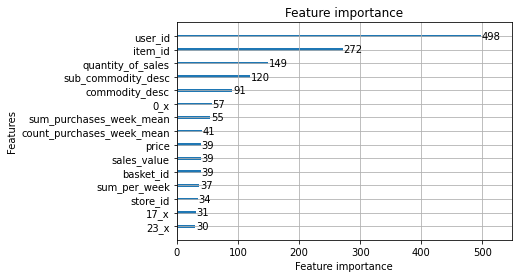

In [39]:
lightgbm.plot_importance(lgb_model, max_num_features=15)

In [40]:
test_preds_proba = lgb_model.predict_proba(X_test[important_feats])[:, 1]

**Сделаем финальную фильтрацию данных**

In [41]:
%%time
gfr = generate_final_recs(X_test, test_preds_proba, data, data_train, item_features)

100%|██████████| 2499/2499 [18:34<00:00,  2.24it/s]

CPU times: user 18min 22s, sys: 41.5 s, total: 19min 4s
Wall time: 18min 35s


In [42]:
price = data_train.groupby('item_id')['price'].mean().reset_index()

**Вычислим money_precision_at_k**

In [43]:
final_pres_result = gfr.apply(lambda row: money_precision_at_k(row['recommendations'], 
                                                               row['actual'], price), axis=1).mean()
final_pres_result

0.4224491007117755

**Сохраним предсказания**

In [44]:
gfr.drop('actual', axis=1, inplace=True)

In [45]:
gfr.head(3)

,user_id,recommendations
0,1,"[874972, 961554, 962568, 1004906, 965766]"
1,2,"[874972, 1053690, 940947, 1133018, 899624]"
2,3,"[874972, 908531, 1133018, 13842214, 1096727]"


In [46]:
recs_count = gfr['recommendations'].apply(lambda x: len(x))
print('Количество рекомендаций не равное 5: ', recs_count.loc[recs_count != 5].shape[0])

Количество рекомендаций не равное 5:  0


In [47]:
gfr.to_csv('TSataev_solution.csv', index=False)